In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import pywt
from torch.utils.data import DataLoader, Dataset , Subset
from torch import nn
import torch
import pickle
import os
from datetime import datetime
import sqlite3
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.tensorboard import SummaryWriter



from torchmetrics.functional.classification.accuracy import accuracy


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training on device: {device}')

Training on device: cuda


In [4]:
class CWTDataset(Dataset):
    def __init__(self, db_path, sequence_length=4000):
        self.db_path = db_path
        self.sequence_length = sequence_length
        self.conn = sqlite3.connect(db_path)
        self.cursor = self.conn.cursor()
        self.cursor.execute("SELECT COUNT(*) FROM wavelet_transforms")
        self.total_samples = self.cursor.fetchone()[0]

    def __len__(self):

        return self.total_samples - self.sequence_length + 1

    def __getitem__(self, idx):

        query = (
            "SELECT cwt_data, target FROM wavelet_transforms WHERE id BETWEEN ? AND ?"
        )

        self.cursor.execute(query, (idx + 1, idx + self.sequence_length))
        rows = self.cursor.fetchall()

        cwt_sequence = np.stack([pickle.loads(row[0]) for row in rows])

        target = rows[-1][1]

        cwt_tensor = torch.tensor(cwt_sequence, dtype=torch.float32)

        target_tensor = torch.tensor(target, dtype=torch.int64)
        return cwt_tensor, target_tensor

    def __del__(self):
        self.conn.close()

In [5]:
class CWTSubset(Dataset): 
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, idx):
        row = self.dataset.__getitem__(int(self.indices[idx]))
        return row
    def __len__(self):
        return len(self.indices)

In [772]:
class CWT_EEG(LightningModule):
    def __init__(
        self,
        batch_size,
        sequence_length,
        input_size,
        hidden_size,
        num_layers,
        lr,
        label_smoothing=0,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.hparams.batch_size = batch_size
        self.hparams.input_size = input_size
        self.hparams.sequence_length = sequence_length
        self.hparams.lr = lr
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_of_classes = 3
        self.val_percent = 0.01
        self.loss = torch.nn.CrossEntropyLoss(label_smoothing=label_smoothing)
        

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, self.num_of_classes)  

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = hn[-1, :, :]  
        out = self.fc(out)

        return out

    # custom
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    # only for HP
    def on_train_start(self):
        self.logger.log_hyperparams(
            self.hparams,
            {
                "hp/train_loss": float("nan"),
                "hp/train_acc": float("nan"),
                "hp/val_loss": float("nan"),
                "hp/val_acc": float("nan"),
            },
        )

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=self.num_of_classes)

        self.log("hp/train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("hp/train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=self.num_of_classes)

        self.log("hp/val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("hp/val_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def generate_validation_indices(self, data_length, num_of_val_samples, sequence_length):
        available_indices = set(range(data_length))  # Tworzymy zbiór dostępnych indeksów

        val_indices = []
        for _ in range(num_of_val_samples):
            if len(available_indices) == 0:
                raise ValueError(
                    "Nie można wygenerować więcej próbek z uwzględnieniem minimalnego dystansu"
                )

            chosen_index = int(np.random.choice(
                list(available_indices))
            )  # Losujemy z dostępnych indeksów
            val_indices.append(chosen_index)

            # Usuwamy indeksy w zakresie `sequence_length` w obie strony od wybranego indeksu
            indices_to_remove = set(
                range(
                    max(0, chosen_index - (2 * sequence_length) - 3),
                    min(data_length, chosen_index + (2 * sequence_length) + 3),
                )
            )
            available_indices.difference_update(
                indices_to_remove
            )  # Aktualizujemy zbiór dostępnych indeksów

        return val_indices
    
    def generate_train_indices(self, data_length, val_i, sequence_length):
        # Ustal minimalną odległość pomiędzy indeksami
        min_distance = sequence_length + 1
        # Utwórz maskę początkową ze wszystkimi wartościami ustawionymi na True
        mask = np.ones(data_length, dtype=bool)

        # Iteruj przez każdy wybrany indeks walidacyjny
        for index in val_i:
            # Ustal zakres indeksów, które należy ustawić na False
            start = max(0, index - min_distance)
            end = min(data_length, index + min_distance + 1)

            # Ustaw odpowiednie wartości w masce na False
            mask[start:end] = False

        # Zwróć indeksy, gdzie maska jest True, czyli indeksy zbioru treningowego
        training_indices = list(np.where(mask)[
            0
        ])  # np.where(mask) zwraca tuple, [0] wyciąga array z indeksami
        return training_indices
    

    def setup(self, stage=None):
        self.ds = CWTDataset("cwt_data.db", self.hparams.sequence_length)
        self.num_val_samples = int(len(self.ds)/(2*self.hparams.sequence_length+1))
        
        val_indices = self.generate_validation_indices(
            len(self.ds), self.num_val_samples, self.hparams.sequence_length
        )
        train_indices = self.generate_train_indices(
            len(self.ds), val_indices, self.hparams.sequence_length
        )
        print("percent of val samples", len(val_indices)/(len(val_indices)+len(train_indices)))
        self.train_set = CWTSubset(self.ds, train_indices)
        self.val_set = CWTSubset(self.ds, val_indices)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_set,
            batch_size=self.hparams.batch_size,
            num_workers=14,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_set, batch_size=self.hparams.batch_size, num_workers=14
        )

    def get_len_train_val(self):
        self.setup()
        return len(self.train_set), len(self.val_set)

In [774]:
lr = 0.001

model = CWT_EEG( batch_size= 11 ,sequence_length =100,input_size=640 , num_layers=3,hidden_size=3, lr=lr).to(device)
logger = TensorBoardLogger("lightning_logs", name="CWT_EEG",default_hp_metric=False)
logger.log_hyperparams(model.hparams, {})
trainer = Trainer(
    max_epochs=2,
    logger=logger

)
print(model.get_len_train_val())
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


percent of val samples 0.041633916290037334
(39017, 1695)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | loss | CrossEntropyLoss | 0     
1 | lstm | LSTM             | 7.9 K 
2 | fc   | Linear           | 12    
------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.032     Total estimated model params size (MB)


percent of val samples 0.04164005306343045
Epoch 1: 100%|██████████| 3547/3547 [00:50<00:00, 70.38it/s, v_num=140, hp/train_loss_step=0.599, hp/train_acc_step=0.800, hp/val_loss_step=0.234, hp/val_acc_step=1.000, hp/val_loss_epoch=0.638, hp/val_acc_epoch=0.745, hp/train_loss_epoch=0.649, hp/train_acc_epoch=0.739]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 3547/3547 [00:50<00:00, 70.37it/s, v_num=140, hp/train_loss_step=0.599, hp/train_acc_step=0.800, hp/val_loss_step=0.234, hp/val_acc_step=1.000, hp/val_loss_epoch=0.638, hp/val_acc_epoch=0.745, hp/train_loss_epoch=0.649, hp/train_acc_epoch=0.739]


In [ ]:
# Utworzenie folderu dla logów
writer = SummaryWriter('./lightning_logs/CWT_EEG')

In [ ]:
dummy_input = torch.randn(11, 10,640).to(device)  # Przykładowe dane wejściowe (batch_size, input_size)
writer.add_graph(model, dummy_input)
writer.close()

In [ ]:
import torch
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size

        # Warstwa LSTM
        self.lstm = nn.LSTM(input_size, hidden_size)


    def forward(self, input_seq):
        # Inicjalizacja stanu ukrytego i stanu komórki
        # (num_layers * num_directions, batch, hidden_size)
        h0 = torch.zeros(1, input_seq.size(1), self.hidden_size)
        c0 = torch.zeros(1, input_seq.size(1), self.hidden_size)

        # Przejście przez LSTM
        lstm_out, _ = self.lstm(input_seq, (h0, c0))


        return lstm_out

# Parametry modelu
input_size = 20  # Wymiary wejściowe (np. cechy)
hidden_size = 10  # Wymiary stanu ukrytego LSTM


# Tworzenie instancji modelu
model = SimpleLSTM(input_size, hidden_size )

dummy_input = torch.randn( 1, 10, 20)  # Przykładowe dane wejściowe (batch_size, input_size)
writer.add_graph(model, dummy_input)
writer.close()
# Wyświetlenie struktury modelu
print(sum(p.numel() for p in model.parameters() if p.requires_grad))


1280


In [ ]:
def create_train_val_split(data_length, val_percent, sequence_length):
    available_lenght = data_length - sequence_length
    val_count = int(val_percent * available_lenght)
    all_indices = np.arange(available_lenght)
    val_indices = np.sort(np.random.choice(all_indices, size=val_count, replace=False))
    mask = np.ones(available_lenght, dtype=bool)
    for idx in val_indices:
        start = max(0, idx - sequence_length + 1)
        end = min(available_lenght, idx + sequence_length)
        mask[start:end] = False
    train_indices = np.where(mask)[0]
    # convert evry number to int
    train_indices = list(train_indices)
    val_indices = list(val_indices)

    return train_indices, val_indices

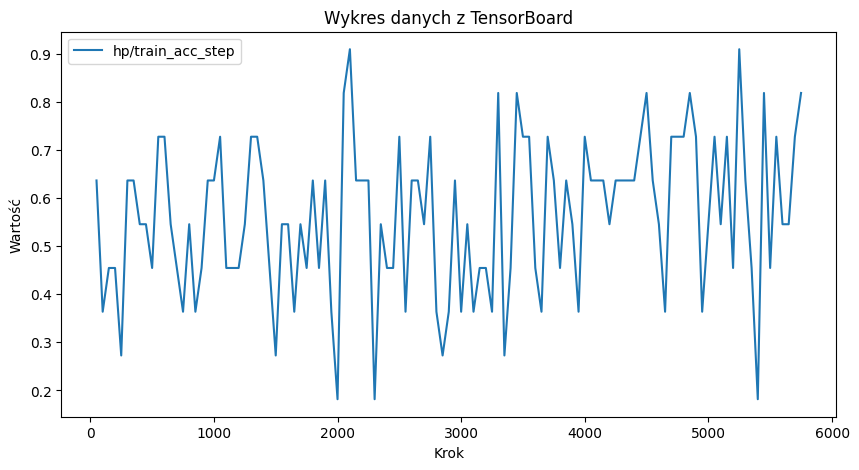

In [ ]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

def load_tensorboard_scalars(logdir):
    # Tworzy akumulator do odczytu danych
    ea = event_accumulator.EventAccumulator(logdir,
        size_guidance={event_accumulator.SCALARS: 0})  # 0 = bez ograniczeń
    ea.Reload()  # Wczytaj wszystkie dane z dysku

    # Odczyt danych skalarnych
    scalars = {}
    for tag in ea.Tags()['scalars']:
        events = ea.Scalars(tag)
        scalars[tag] = [(e.wall_time, e.step, e.value) for e in events]

    return scalars

# Ścieżka do katalogu z logami TensorBoard
logdir = '/home/daniel/repos/Decoding_of_EEG/lightning_logs/CWT_EEG/version_51/events.out.tfevents.1713204451.pop-os.32833.5'

# Wczytanie danych
scalars = load_tensorboard_scalars(logdir)

# Przykład wyświetlenia danych skalarnych
tag = 'hp/train_acc_step'  # Zmień na odpowiedni tag, który chcesz wyświetlić
times, steps, values = zip(*scalars[tag])

plt.figure(figsize=(10, 5))
plt.plot(steps, values, label=tag)
plt.xlabel('Krok')
plt.ylabel('Wartość')
plt.title('Wykres danych z TensorBoard')
plt.legend()
plt.show()


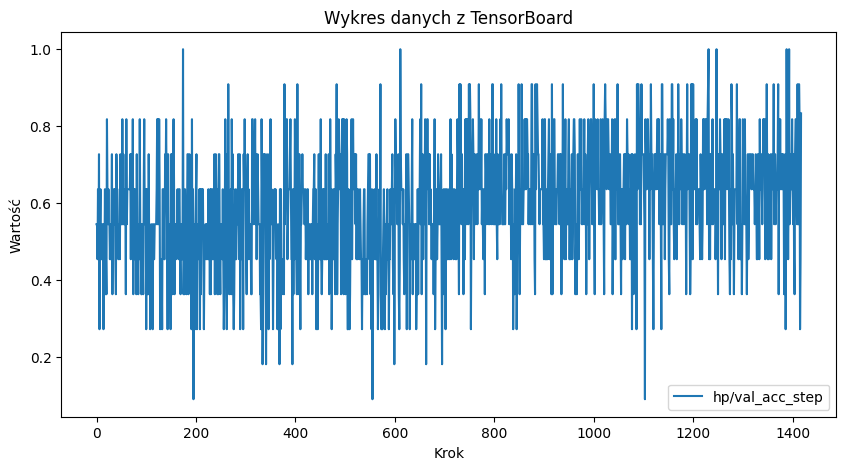

In [ ]:
tag = 'hp/val_acc_step'  # Zmień na odpowiedni tag, który chcesz wyświetlić
times, steps, values = zip(*scalars[tag])

plt.figure(figsize=(10, 5))
plt.plot(steps, values, label=tag)
plt.xlabel('Krok')
plt.ylabel('Wartość')
plt.title('Wykres danych z TensorBoard')
plt.legend()
plt.show()

In [230]:
import numpy as np

def generate_validation_indices(data_length, num_of_val_samples, sequence_length):
    # Ustal minimalną odległość pomiędzy indeksami
    min_distance = sequence_length + 1
    # Utwórz set możliwych indeksów
    available_indices = set(range(data_length))

    chosen_indices = []
    for i in range(num_of_val_samples):
        if not available_indices:
            raise ValueError("Nie można wygenerować więcej próbek z uwzględnieniem minimalnego dystansu")

        # Losuj indeks z dostępnych indeksów
        chosen_index = np.random.choice(list(available_indices))
        chosen_indices.append(chosen_index)

        # Oblicz zakres indeksów do usunięcia
        start = max(0, chosen_index - (2* min_distance))
        end = min(data_length, chosen_index + min_distance)

        # Usuń indeksy zbyt blisko wybranego indeksu z zbioru available_indices
        for idx in range(start, end + 1):
            available_indices.discard(idx)  # discard nie zgłasza błędu, jeśli element nie istnieje

        # Wydrukuj postęp
        print(f"Postęp: {i + 1}/{num_of_val_samples} indeksów wygenerowanych. ({(i + 1) / num_of_val_samples * 100:.2f}%)")

    return chosen_indices

# Przykładowe wywołanie funkcji
data_length = 10000
num_of_val_samples = 10
sequence_length = 200

try:
    val_indices = generate_validation_indices(data_length, num_of_val_samples, sequence_length)
    print("Wygenerowane indeksy walidacyjne:", val_indices)
    print("len(val_indices):", len(val_indices))
except ValueError as e:
    print(e)


Postęp: 1/10 indeksów wygenerowanych. (10.00%)
Postęp: 2/10 indeksów wygenerowanych. (20.00%)
Postęp: 3/10 indeksów wygenerowanych. (30.00%)
Postęp: 4/10 indeksów wygenerowanych. (40.00%)
Postęp: 5/10 indeksów wygenerowanych. (50.00%)
Postęp: 6/10 indeksów wygenerowanych. (60.00%)
Postęp: 7/10 indeksów wygenerowanych. (70.00%)
Postęp: 8/10 indeksów wygenerowanych. (80.00%)
Postęp: 9/10 indeksów wygenerowanych. (90.00%)
Postęp: 10/10 indeksów wygenerowanych. (100.00%)
Wygenerowane indeksy walidacyjne: [5020, 2423, 9617, 3842, 8888, 8443, 2879, 3168, 7700, 9187]
len(val_indices): 10


In [239]:
import numpy as np

def generate_validation_indices(data_length, num_of_val_samples, sequence_length):
    # Ustal minimalną odległość pomiędzy indeksami
    min_distance_forward = sequence_length + 1
    min_distance_backward = 2 * sequence_length + 1
    print("min_distance_forward:", min_distance_forward)
    print("min_distance_backward:", min_distance_backward)
    # Utwórz listę możliwych indeksów
    available_indices = list(range(data_length))

    chosen_indices = []
    for i in range(num_of_val_samples):
        if not available_indices:
            raise ValueError("Nie można wygenerować więcej próbek z uwzględnieniem minimalnego dystansu")
        array = np.array(available_indices)
        # Losuj indeks z dostępnych indeksów
        chosen_index = np.random.choice(available_indices)
        chosen_indices.append(chosen_index)

        # Oblicz zakres indeksów do usunięcia
        start = max(0, chosen_index -  min_distance_backward)
        end = min(data_length, chosen_index + min_distance_forward)

        # Usuń indeksy zbyt blisko wybranego indeksu
        available_indices = [idx for idx in available_indices if idx < start or idx > end]
        print("len(available_indices):", len(available_indices))
        # Wydrukuj postęp
        print(f"Postęp: {i + 1}/{num_of_val_samples} indeksów wygenerowanych. ({(i + 1) / num_of_val_samples * 100:.2f}%)")

    return chosen_indices

# Przykładowe wywołanie funkcji
data_length = 100
num_of_val_samples = 100
sequence_length = 200

try:
    val_indices = generate_validation_indices(data_length, num_of_val_samples, sequence_length)
    print("Wygenerowane indeksy walidacyjne:", val_indices)
    print("len(val_indices):", len(val_indices))
except ValueError as e:
    print(e)


min_distance_forward: 201
min_distance_backward: 401
len(available_indices): 0
Postęp: 1/100 indeksów wygenerowanych. (1.00%)
Nie można wygenerować więcej próbek z uwzględnieniem minimalnego dystansu


In [462]:
import numpy as np

def generate_validation_indices(data_length, num_of_val_samples, sequence_length):
    min_distance = sequence_length + 1  # Minimalna odległość pomiędzy indeksami
    available_indices = set(range(data_length))  # Tworzymy zbiór dostępnych indeksów

    chosen_indices = []
    for _ in range(num_of_val_samples):
        if len(available_indices) == 0:
            raise ValueError("Nie można wygenerować więcej próbek z uwzględnieniem minimalnego dystansu")
        
        chosen_index = np.random.choice(list(available_indices))  # Losujemy z dostępnych indeksów
        chosen_indices.append(chosen_index)

        # Usuwamy indeksy w zakresie `sequence_length` w obie strony od wybranego indeksu
        indices_to_remove = set(range(max(0, chosen_index - (2* sequence_length ) - 3 ),
                                      min(data_length, chosen_index + (2 * sequence_length) + 3 )))
        available_indices.difference_update(indices_to_remove)  # Aktualizujemy zbiór dostępnych indeksów

    return chosen_indices

# Przykładowe wywołanie funkcji
data_length = 1000
num_of_val_samples = 10
sequence_length = 50

try:
    val_indices = generate_validation_indices(data_length, num_of_val_samples, sequence_length)
    print("Wygenerowane indeksy walidacyjne:", val_indices)
except ValueError as e:
    print(e)


Nie można wygenerować więcej próbek z uwzględnieniem minimalnego dystansu


In [603]:
import numpy as np

def generate_mask(data_length, chosen_indices, sequence_length):
    # Ustal minimalną odległość pomiędzy indeksami
    min_distance = sequence_length + 1
    # Utwórz maskę początkową ze wszystkimi wartościami ustawionymi na True
    mask = np.ones(data_length, dtype=bool)

    # Iteruj przez każdy wybrany indeks walidacyjny
    for index in chosen_indices:
        # Ustal zakres indeksów, które należy ustawić na False
        start = max(0, index - min_distance)
        end = min(data_length, index + min_distance)

        # Ustaw odpowiednie wartości w masce na False
        mask[start:end] = False

    # Zwróć indeksy, gdzie maska jest True, czyli indeksy zbioru treningowego
    training_indices = np.where(mask)[0]  # np.where(mask) zwraca tuple, [0] wyciąga array z indeksami
    return training_indices



chosen_index: 25935 chosen_value: 25935

chosen_index: 29269 chosen_value: 29303

chosen_index: 41309 chosen_value: 41377

chosen_index: 29574 chosen_value: 29642

chosen_index: 18561 chosen_value: 18561

chosen_index: 21707 chosen_value: 21741

chosen_index: 46743 chosen_value: 46947

chosen_index: 9132 chosen_value: 9132

chosen_index: 71023 chosen_value: 71295

chosen_index: 60798 chosen_value: 61070

chosen_index: 76986 chosen_value: 77326

chosen_index: 52752 chosen_value: 53024

chosen_index: 567 chosen_value: 567

chosen_index: 19318 chosen_value: 19420

chosen_index: 72284 chosen_value: 72726

chosen_index: 12876 chosen_value: 12944

chosen_index: 67313 chosen_value: 67755

chosen_index: 50848 chosen_value: 51222

chosen_index: 74197 chosen_value: 74775

chosen_index: 16491 chosen_value: 16593

chosen_index: 41291 chosen_value: 41665

chosen_index: 38614 chosen_value: 38954

chosen_index: 25799 chosen_value: 26071

chosen_index: 59857 chosen_value: 60419

chosen_index: 55023 ch

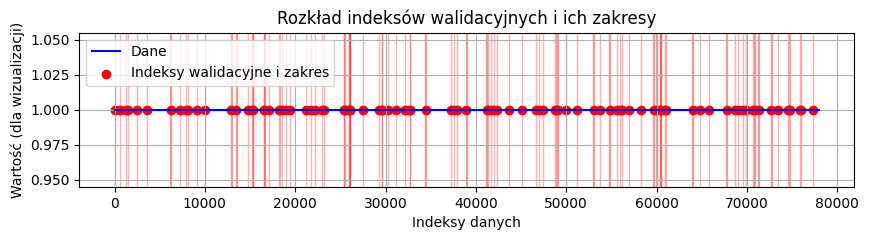

In [759]:
import matplotlib.pyplot as plt
import numpy as np

def plot_val_indices(data_length, val_indices,   sequence_length):
    # Ustal minimalną odległość pomiędzy indeksami
    min_distance = sequence_length + 1

    # Inicjalizacja figury
    plt.figure(figsize=(10, 2))
    plt.title("Rozkład indeksów walidacyjnych i ich zakresy")
    plt.xlabel("Indeksy danych")
    plt.ylabel("Wartość (dla wizualizacji)")

    # Rysowanie linii dla całej długości danych
    plt.plot([0, data_length - 1], [1, 1], label='Dane', color='blue')

    # Rysowanie punktów dla walidacyjnych indeksów
    for index in val_indices:
        plt.scatter([index], [1], color='red')  # punkt walidacyjny
        start = max(0, index - min_distance)
        end = min(data_length, index + min_distance)
        plt.axvspan(start, end, color='red', alpha=0.3)  # zakres wokół punktu)


    plt.legend(['Dane', 'Indeksy walidacyjne i zakres'])
    plt.grid(True)
    plt.show()

# Przykładowe wywołanie funkcji
data_length = 77991
num_of_val_samples = 100
sequence_length = 10

try:
    val_indices = generate_validation_indices(data_length, num_of_val_samples, sequence_length)
    plot_val_indices(data_length, val_indices, sequence_length)
except ValueError as e:
    print(e)

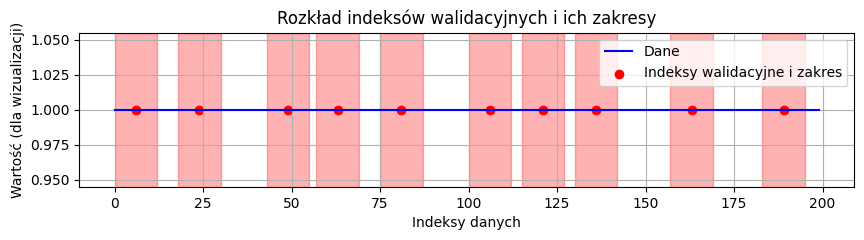

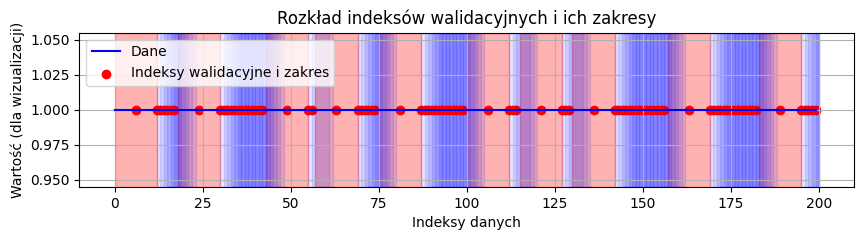

In [605]:
import matplotlib.pyplot as plt
import numpy as np

def plot_train_val_indices(data_length, train_indices, val_indices,   sequence_length):
    # Ustal minimalną odległość pomiędzy indeksami
    min_distance = sequence_length + 1

    # Inicjalizacja figury
    plt.figure(figsize=(10, 2))
    plt.title("Rozkład indeksów walidacyjnych i ich zakresy")
    plt.xlabel("Indeksy danych")
    plt.ylabel("Wartość (dla wizualizacji)")

    # Rysowanie linii dla całej długości danych
    plt.plot([0, data_length - 1], [1, 1], label='Dane', color='blue')

    # Rysowanie punktów dla walidacyjnych indeksów
    for index in val_indices:
        plt.scatter([index], [1], color='red')  # punkt walidacyjny
        start = max(0, index - min_distance)
        end = min(data_length, index + min_distance)
        plt.axvspan(start, end, color='red', alpha=0.3)  # zakres wokół punktu)
    # if train_indices is not empty:
    for index in train_indices:
        plt.scatter([index], [1], color='red')  # punkt walidacyjny
        start = index
        end = min(data_length, index + min_distance)
        plt.axvspan(start, end, color='blue', alpha=0.1)  # zakres wokół punktu)

    plt.legend(['Dane', 'Indeksy walidacyjne i zakres'])
    plt.grid(True)
    plt.show()

# Przykładowe wywołanie funkcji
data_length = 200
num_of_val_samples = 10
sequence_length = 5

try:
    val_indices = generate_validation_indices(data_length, num_of_val_samples, sequence_length)
    train_indices = generate_mask(data_length, val_indices, sequence_length)
    plot_val_indices(data_length, val_indices, sequence_length)
    plot_train_val_indices(data_length, train_indices, val_indices, sequence_length)
except ValueError as e:
    print(e)

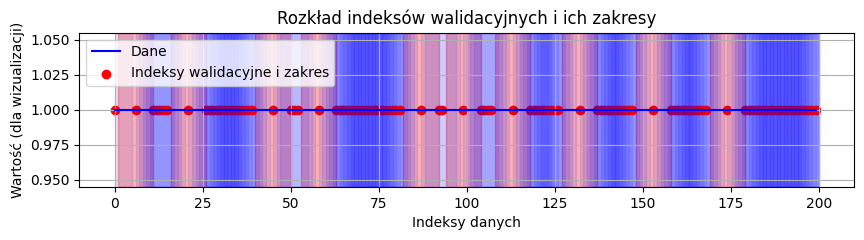

Wygenerowane indeksy walidacyjne: [99, 6, 174, 58, 132, 153, 45, 87, 21, 113]
Indeksy zbioru treningowego: [  0  11  12  13  14  15  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  50  51  52  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  92  93 104 105 106 107 118 119 120 121 122 123
 124 125 126 137 138 139 140 141 142 143 144 145 146 147 158 159 160 161
 162 163 164 165 166 167 168 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199]


In [ ]:
import numpy as np

def generate_mask(data_length, chosen_indices, sequence_length):
    # Ustal minimalną odległość pomiędzy indeksami
    min_distance = sequence_length + 1
    # Utwórz maskę początkową ze wszystkimi wartościami ustawionymi na True
    mask = np.ones(data_length, dtype=bool)

    # Iteruj przez każdy wybrany indeks walidacyjny
    for index in chosen_indices:
        # Ustal zakres indeksów, które należy ustawić na False
        start = max(0, index - min_distance)
        end = min(data_length, index + min_distance)

        # Ustaw odpowiednie wartości w masce na False
        mask[start:end] = False

    # Zwróć indeksy, gdzie maska jest True, czyli indeksy zbioru treningowego
    training_indices = np.where(mask)[0]  # np.where(mask) zwraca tuple, [0] wyciąga array z indeksami
    return training_indices

# Przykładowe wywołanie funkcji
data_length = 200
num_of_val_samples = 10
sequence_length = 4

try:
    val_indices = generate_validation_indices(data_length, num_of_val_samples, sequence_length)
    training_indices = generate_mask(data_length, val_indices, sequence_length)
    plot_validation_indices(data_length,training_indices, val_indices, sequence_length)
    print("Wygenerowane indeksy walidacyjne:", val_indices)
    print("Indeksy zbioru treningowego:", training_indices)
except ValueError as e:
    print(e)


In [ ]:
randomlist= [1,2,9,10]
index = np.random.choice(randomlist)
index

2

In [732]:
# Przykładowe wywołanie funkcji
data_length = 1000
num_of_val_samples = 10
sequence_length = 30

try:
    val_indices = generate_validation_indices(data_length, num_of_val_samples, sequence_length)
    training_indices = generate_mask(data_length, val_indices, sequence_length)
    print("len(training_indices):", len(training_indices))
except ValueError as e:
    print(e)


len(training_indices): 399
